In [81]:
import json

import numpy as np
import pandas as pd
import pymongo
import scipy
from bson import ObjectId, json_util
from pandas.io.json import json_normalize
from pymongo import MongoClient as Connection
from scipy import sparse, spatial
from scipy.spatial.distance import cdist, pdist, squareform
from sklearn.metrics.pairwise import cosine_similarity

# scientific notation disabled form smaller numbers
pd.options.display.float_format = '{:.5f}'.format

# alles resultate anzeigen und nicht nur das letzte
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"



In [82]:
# display multiple outputs in one row
import pandas as pd
import numpy as np
from IPython.display import display, HTML

CSS = """
.output {
    flex-direction: row;
}
"""

HTML('<style>{}</style>'.format(CSS))

In [83]:
connection = Connection()
db = connection.recipe_db
input_data = db.recipes_test_copy

data = json.loads(json_util.dumps(input_data.find()))

In [84]:
ing = pd.DataFrame(json_normalize(data, record_path='ingredients',
                             meta='id', record_prefix='ingredients_', errors='ignore'))


nutritions = pd.DataFrame(json_normalize(data, record_path='nutritions',
                            meta=['id', 'prep_time', 'rating', 'rating_count', 'ready_in_time', 'review_count']))


In [85]:
#ingredients
#ingredients.loc[ingredients['id'] == 9380]

In [86]:
#ingredients.loc[ingredients['ingredients_id'] == 2972]

In [87]:
#  ------  erstellung und data cleansing - Ingredients

# schmeiss alle zutaten raus, die weniger als 5 mal verwendet werden
# setze multiinde auf 'id' und 'ingredients_id'
ingredients = ing.set_index(['id', 'ingredients_id'])

# filtere alle Zutaten samt ihrer rezepte id, die weniger gleich 5 mal vorkommen
ingredients_eqles_5_ing = ingredients.groupby(
    'ingredients_id').filter(lambda x: len(x) <= 5)

# droppe alle rezepte, die eine Zutate besitzen, die weniger gleich 5 Mal vorkommen
ingredients_filt = ingredients.drop(ingredients_eqles_5_ing.index.get_level_values('id').values, level=0)

# drop alls rows with ingredients_id == 0
ingredients_eqal_zero = ingredients_filt[ingredients_filt.index.get_level_values('ingredients_id') == 0]
ingredients_filt = ingredients_filt.drop(ingredients_eqal_zero.index.get_level_values('id').values, level=0)


In [88]:
#  ------ Erstellung und cleansing des Nutrition Dataframes

# erstelle neue liste auf basis der bereits gefilterten rezepte aus ingredients_filt
id_overlap_mask = nutritions['id'].isin(ingredients_filt.index.get_level_values('id').values)

# erstelle datenframe auf basis der overlapliste
nutritions_filt = nutritions.loc[id_overlap_mask]

nutrition_db = nutritions_filt.pivot_table(
    index=['id'],
    columns=['name'],
    values=['amount'],
).reset_index()

nutrition_db.set_index('id', inplace=True)

# remove multiindex 'amount'
nutrition_db.columns = nutrition_db.columns.droplevel(0)

# entferne alle NA
nutrition_db = nutrition_db.dropna()

# gleiche nochmals die ids der beiden dataframe nutrition und ingredients ab, da der nutrition dataframe noch NA Werte hatt
id_overlap_mask = ingredients_filt.index.get_level_values('id').isin(nutrition_db.index)
ingredients_db = ingredients_filt[id_overlap_mask]

# abgleich ob anzahl der indizes von nutrition und zutaten dataframe gleich sind


In [89]:
nutrition_db.index.nunique()
ingredients_db.index.get_level_values('id').nunique()


4061

4061

In [90]:


ingredients_db.reset_index(inplace=True)

recipe_db = pd.get_dummies(ingredients_db['ingredients_id']).groupby(
    ingredients_db['id']).apply(max)



In [91]:
recipe_db

,111,126,257,443,445,578,615,629,631,858,...,23047,23274,23383,24865,25518,25522,26269,26934,27343,27805
id,,,,,,,,,,,,,,,,,,,,,
6900,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7198,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8493,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8494,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8495,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
258878,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
259870,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
260193,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [92]:
new_ingredients = ingredients_db.copy()
#new_ingredients = new_ingredients.groupby("id")["ingredients_grams"].sum().reset_index()

In [93]:
gramms_ingredients = new_ingredients.groupby("id")["ingredients_grams"].sum().reset_index().copy()

In [94]:
gramms_ingredients

,id,ingredients_grams
0,6900,184.35112
1,7198,1238.50889
2,8493,1280.50000
3,8494,1671.56307
4,8495,817.26250
...,...,...
4056,258878,456.93333
4057,259870,3484.50000
4058,260193,1464.50000
4059,261124,1156.96946


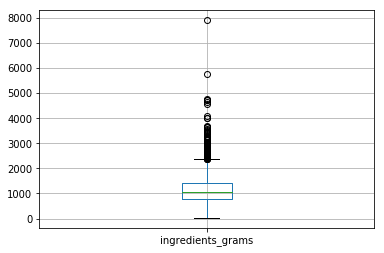

In [95]:
gramms_ingredients.boxplot(['ingredients_grams'])

In [96]:
Q1 = gramms_ingredients.quantile(0.25)
Q3 = gramms_ingredients.quantile(0.75)
IQR = Q3 - Q1

df = gramms_ingredients[~((gramms_ingredients < (Q1 - 1.5 * IQR)) |(gramms_ingredients > (Q3 + 1.5 * IQR))).any(axis=1)].copy()

In [97]:
df_start_at_fivehundret = df[df['ingredients_grams'].between(500, 2373.58225, inclusive=False)].copy()

In [98]:
df_start_at_fivehundret.set_index('id', inplace=True)

In [99]:
df_start_at_fivehundret

,ingredients_grams
id,
7198,1238.50889
8493,1280.50000
8494,1671.56307
8495,817.26250
8496,1095.50000
...,...
255936,1551.26673
257312,791.33334
260193,1464.50000


In [100]:
id_overlap_mask = nutritions['id'].isin(df_start_at_fivehundret.index.get_level_values('id').values)


In [101]:

# erstelle datenframe auf basis der overlapliste
nutritions_filt_gramm = nutritions.loc[id_overlap_mask]

nutrition_db2 = nutritions_filt_gramm.pivot_table(
    index=['id'],
    columns=['name'],
    values=['amount'],
).reset_index()

nutrition_db2.set_index('id', inplace=True)
nutrition_db2.columns = nutrition_db2.columns.droplevel(0)

In [102]:
nutrition_db2

name,Calcium,Calories,Calories from Fat,Carbohydrates,Cholesterol,Dietary Fiber,Fat,Folate,Iron,Magnesium,Niacin Equivalents,Potassium,Protein,Saturated Fat,Sodium,Sugars,Thiamin,Vitamin A - IU,Vitamin B6,Vitamin C
id,,,,,,,,,,,,,,,,,,,,
7198,244.16520,731.50920,325.65230,73.29574,88.69389,4.64147,36.18359,249.14210,5.76566,52.89296,13.51325,509.34610,27.58195,11.50691,1660.20300,2.83424,0.89150,699.95980,0.36319,67.32533
8493,415.52450,454.28300,177.75310,23.83120,203.86850,1.99500,19.75034,63.05025,3.11258,54.35775,23.43780,509.41500,44.07647,9.96063,1107.91100,3.45304,0.17406,578.21420,0.64563,1.91250
8494,58.08641,834.44480,514.68470,4.76954,283.75000,0.63600,57.18719,33.44816,3.72336,84.44925,39.18463,807.96980,71.10712,16.35430,567.97140,2.08741,0.02921,619.52510,1.37244,20.17546
8495,379.01410,418.75340,174.23740,12.62089,123.58900,0.75239,19.35971,25.41156,1.89411,60.48306,24.62857,457.03550,46.06678,10.03598,931.58340,1.42275,0.29605,406.88370,0.82640,11.72893
8496,24.76875,375.33620,157.43640,16.99219,112.31000,0.28125,17.49294,7.31875,1.70651,34.97875,17.54741,382.10380,34.84163,4.83699,629.18380,12.21562,0.09447,315.63250,0.52972,0.32812
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
255936,44.16983,664.02470,412.33830,28.15322,153.01330,3.52210,45.81537,39.57017,2.57701,42.93500,9.23293,547.95030,33.76503,14.12975,1288.01600,2.84453,0.53221,1438.83900,0.67638,55.83233
257312,32.15334,233.78670,84.37980,21.16250,52.78000,1.35967,9.37553,15.76667,1.62800,29.24167,6.97295,282.97170,16.71655,2.61999,1252.53700,17.03263,0.08388,242.77830,0.28177,34.28000
260193,37.24250,300.08690,43.28884,13.86486,118.04670,1.03600,4.80987,7.15000,1.63545,46.19250,21.66052,476.54750,45.85212,1.41095,1545.54100,4.58523,0.08974,217.95000,0.61491,1.23025


In [165]:
subset_fat = nutrition_db2[(nutrition_db2['Fat'] >= 35) & (nutrition_db2['Fat'] <= 40)].sample(n=10).copy()

In [104]:
subset_random = nutrition_db2.sample(n=10).copy()
subset_random = subset_random.index.to_numpy()

In [105]:
subset_random


array([ 26639, 134471,  22671, 132511,  71418,   8597, 232102,  17449,
        22760,  11913])

In [166]:
subset_fat_20 = subset_fat.index.to_numpy()

In [186]:
subset_fat_20

array([ 16565, 218085,  18439,  72277, 169322,  86415, 214478, 223005,
       229972, 161869])

In [108]:
recipe_db

,111,126,257,443,445,578,615,629,631,858,...,23047,23274,23383,24865,25518,25522,26269,26934,27343,27805
id,,,,,,,,,,,,,,,,,,,,,
6900,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7198,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8493,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8494,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8495,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
258878,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
259870,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
260193,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [109]:
recipe_db[recipe_db.mask(recipe_db==0).count(axis=1) >= 5]


,111,126,257,443,445,578,615,629,631,858,...,23047,23274,23383,24865,25518,25522,26269,26934,27343,27805
id,,,,,,,,,,,,,,,,,,,,,
6900,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7198,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8493,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8494,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8495,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
257054,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
257312,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
259870,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [110]:
# remove recipes which are missing in nutrition df from the ingredients tecipes dataframe
mask = recipe_db.index.isin(nutrition_db2.index.values)
recipe_db = recipe_db.loc[mask]

recipe_db

,111,126,257,443,445,578,615,629,631,858,...,23047,23274,23383,24865,25518,25522,26269,26934,27343,27805
id,,,,,,,,,,,,,,,,,,,,,
7198,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8493,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8494,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8495,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8496,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
255936,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
257312,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
260193,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [169]:
id_list = subset_fat_20.copy()

user_recipes = recipe_db[recipe_db.index.isin(id_list)]

In [170]:
user_recipes


,111,126,257,443,445,578,615,629,631,858,...,23047,23274,23383,24865,25518,25522,26269,26934,27343,27805
id,,,,,,,,,,,,,,,,,,,,,
16565,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
18439,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
72277,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
86415,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
161869,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
169322,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
214478,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
218085,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
223005,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [113]:
drop_id_list = [4342, 6307, 6494, 16157, 16278, 16421]

In [180]:
new_user_recipes = user_recipes.drop(axis=1, labels=drop_id_list)

In [181]:
new_user_recipes

,111,126,257,443,445,578,615,629,631,858,...,23047,23274,23383,24865,25518,25522,26269,26934,27343,27805
id,,,,,,,,,,,,,,,,,,,,,
16565,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
18439,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
72277,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
86415,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
161869,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
169322,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
214478,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
218085,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
223005,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [179]:
new_user_recipes_clean = new_user_recipes.drop(axis=0, labels=subset_fat_20)

In [115]:
user_recipes

,111,126,257,443,445,578,615,629,631,858,...,23047,23274,23383,24865,25518,25522,26269,26934,27343,27805
id,,,,,,,,,,,,,,,,,,,,,
8547,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8875,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11798,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11892,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
15024,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
16794,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
20718,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
23923,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
26299,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [172]:
new_user_recipes

,111,126,257,443,445,578,615,629,631,858,...,23047,23274,23383,24865,25518,25522,26269,26934,27343,27805
id,,,,,,,,,,,,,,,,,,,,,
16565,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
18439,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
72277,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
86415,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
161869,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
169322,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
214478,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
218085,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
223005,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [182]:
new_recipe_db = recipe_db.drop(axis=1, labels=drop_id_list)
new_recipe_db_wo_userrecipes = new_recipe_db.drop(axis=0, labels=subset_fat_20)

In [184]:
## Jaccard - rezept zu rezept vergelich

result_array = cdist(new_user_recipes, new_recipe_db_wo_userrecipes,'jaccard')
result_2 = pd.DataFrame(result_array, columns=new_recipe_db_wo_userrecipes.index.values, index=new_user_recipes.index.values)
# result_2

new_result_10 = pd.DataFrame(result_2.sum(), columns=['jaccard_distance_sum'])
new_result_10 = new_result_10.sort_values(by='jaccard_distance_sum')

new_result_10[0:10]


,jaccard_distance_sum
19422,8.93333
52608,8.97732
19368,9.01667
11683,9.02274
11735,9.05000
25318,9.11108
18805,9.11190
132511,9.11617
158587,9.12429
228806,9.12602


In [185]:
new_result_10[0:10].index.to_numpy()

array([ 19422,  52608,  19368,  11683,  11735,  25318,  18805, 132511,
       158587, 228806])

In [183]:
new_recipe_db_wo_userrecipes

,111,126,257,443,445,578,615,629,631,858,...,23047,23274,23383,24865,25518,25522,26269,26934,27343,27805
id,,,,,,,,,,,,,,,,,,,,,
7198,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8493,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8494,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8495,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8496,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
255936,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
257312,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
260193,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [118]:
recipe_db

,111,126,257,443,445,578,615,629,631,858,...,23047,23274,23383,24865,25518,25522,26269,26934,27343,27805
id,,,,,,,,,,,,,,,,,,,,,
7198,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8493,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8494,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8495,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8496,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
255936,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
257312,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
260193,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [157]:
new_recipe_db[111]

id
7198      0
8493      0
8494      0
8495      0
8496      0
         ..
255936    0
257312    0
260193    0
261124    0
263813    0
Name: 111, Length: 3769, dtype: uint8

In [176]:
## Jaccard - rezept zu rezept vergelich

result_array = cdist(new_user_recipes, new_recipe_db,'jaccard')
result_2 = pd.DataFrame(result_array, columns=new_recipe_db.index.values, index=new_user_recipes.index.values)
# result_2

new_result_10 = pd.DataFrame(result_2.sum(), columns=['jaccard_distance_sum'])
new_result_10 = new_result_10.sort_values(by='jaccard_distance_sum')

new_result_10[0:10]


,jaccard_distance_sum
161869,8.53274
86415,8.62271
72277,8.64133
18439,8.66667
223005,8.77251
229972,8.80556
16565,8.85641
214478,8.88889
169322,8.92857
218085,8.93333


In [163]:
result_2[23923]

8547     0.93333
8875     0.84615
11798    0.93333
11892    1.00000
15024    1.00000
16794    0.94118
20718    0.81250
23923    0.00000
26299    1.00000
40286    0.84615
48873    1.00000
60070    1.00000
69538    1.00000
90233    1.00000
106528   0.92857
206633   1.00000
214478   1.00000
216026   1.00000
229247   0.94737
237240   1.00000
Name: 23923, dtype: float64

In [177]:
new_result_10[0:10].index.to_numpy()

array([161869,  86415,  72277,  18439, 223005, 229972,  16565, 214478,
       169322, 218085])

In [121]:
## Jaccard - rezept zu rezept vergelich

result_array = cdist(user_recipes, recipe_db,'jaccard')
result_2 = pd.DataFrame(result_array, columns=recipe_db.index.values, index=user_recipes.index.values)
# result_2

result_10 = pd.DataFrame(result_2.sum(), columns=['jaccard_distance_sum'])
result_10 = result_10.sort_values(by='jaccard_distance_sum')

result_10[0:10]


,jaccard_distance_sum
8611,16.82509
26284,16.84916
15003,16.88648
70522,16.90609
71291,16.93405
165522,16.94308
239137,17.01335
19886,17.05213
214478,17.08156
48873,17.08606


In [122]:
result_10.index.name = 'id'

In [123]:
result_10[0:10].index.to_numpy()

array([  8611,  26284,  15003,  70522,  71291, 165522, 239137,  19886,
       214478,  48873])

In [124]:
result_10[0:100]

,jaccard_distance_sum
id,
8611,16.82509
26284,16.84916
15003,16.88648
70522,16.90609
71291,16.93405
...,...
42824,17.52680
213140,17.53008
20393,17.53343


In [125]:
result_2

,7198,8493,8494,8495,8496,8497,8498,8500,8503,8506,...,254874,254940,255038,255263,255545,255936,257312,260193,261124,263813
8547,0.95652,0.78571,1.00000,0.85714,1.00000,0.76923,0.92857,0.83333,0.87500,0.94118,...,0.87500,0.93333,0.95652,0.93750,1.00000,0.95000,0.94118,0.92308,0.89474,0.82353
8875,0.95238,0.92857,0.94444,0.83333,0.75000,0.92308,1.00000,0.88235,0.93333,1.00000,...,0.93333,0.83333,0.84211,0.75000,0.94737,0.88235,0.85714,1.00000,0.73333,0.87500
11798,0.90476,0.85714,0.94737,1.00000,1.00000,0.92857,1.00000,1.00000,0.93750,1.00000,...,0.93750,0.92857,1.00000,1.00000,0.95000,1.00000,0.93750,1.00000,0.88889,0.94444
11892,0.95000,0.92308,1.00000,1.00000,1.00000,0.91667,1.00000,1.00000,0.92857,1.00000,...,0.92857,0.91667,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,0.93750
15024,1.00000,0.75000,1.00000,0.71429,1.00000,0.87500,0.85714,0.92308,0.90000,0.90000,...,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,0.83333,1.00000,1.00000
16794,0.95833,0.80000,1.00000,0.86667,1.00000,0.86667,0.93333,0.84211,0.94444,0.88235,...,0.94444,0.93750,0.91304,0.94118,0.95455,0.95238,0.94444,0.92857,0.90000,0.89474
20718,0.87500,0.94737,0.95652,0.88235,1.00000,0.94444,0.94118,0.90909,0.95000,0.89474,...,0.89474,0.94444,0.87500,0.94737,0.91304,0.95652,0.89474,0.93750,0.85714,0.95455
23923,0.90909,1.00000,0.95000,0.85714,1.00000,1.00000,0.84615,0.89474,0.87500,1.00000,...,0.94118,0.85714,0.73684,0.78571,0.84211,0.89474,0.80000,1.00000,0.83333,0.94737
26299,0.89474,0.83333,1.00000,1.00000,1.00000,1.00000,1.00000,0.94118,1.00000,1.00000,...,0.92857,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000
40286,0.84211,1.00000,0.94444,0.92308,1.00000,1.00000,1.00000,0.94444,1.00000,1.00000,...,0.85714,0.92308,0.90000,0.92857,0.88889,1.00000,0.93333,1.00000,0.88235,0.94118


In [126]:
df2 = result_2.loc[(result_2 == 1).all(axis=1), :]

In [127]:
result_2['lowest_col'] = result_2.idxmin(axis=1)


In [128]:
result_2['lowest_col']

8547        8547
8875        8875
11798      11798
11892      11892
15024      15024
16794      16794
20718      20718
23923      23923
26299      26299
40286      40286
48873      48873
60070      60070
69538      69538
90233      90233
106528    106528
206633    206633
214478    214478
216026    216026
229247    229247
237240    237240
Name: lowest_col, dtype: int64

In [129]:
result_2[11757]

8547     0.89474
8875     0.88235
11798    0.82353
11892    0.94118
15024    1.00000
16794    1.00000
20718    0.95652
23923    0.89474
26299    0.94118
40286    0.94444
48873    0.92857
60070    0.94118
69538    1.00000
90233    1.00000
106528   1.00000
206633   0.88889
214478   0.87500
216026   0.95238
229247   0.86364
237240   0.90909
Name: 11757, dtype: float64

In [130]:
result_2.loc[:, (result_2 == 0).any(axis=0)]

,8547,8757,8875,11798,11892,15024,15030,16794,20718,23923,...,48873,60070,69538,90233,106528,206633,214478,216026,229247,237240
8547,0.00000,0.00000,0.87500,0.94444,0.78571,0.91667,0.91667,0.95000,0.95455,0.94737,...,0.83333,0.86667,0.84615,1.00000,0.93750,0.88235,0.93750,0.89474,0.90909,0.90476
8875,0.87500,0.87500,0.00000,0.93750,0.92857,1.00000,1.00000,0.88235,0.89474,0.80000,...,0.80000,0.84615,1.00000,1.00000,0.92857,0.93750,0.75000,0.88235,0.84211,0.89474
11798,0.94444,0.94444,0.93750,0.00000,0.93333,1.00000,1.00000,0.94737,0.90000,0.94444,...,0.91667,0.93333,1.00000,1.00000,1.00000,0.94118,0.85714,0.88889,0.90476,0.95238
11892,0.78571,0.78571,0.92857,0.93333,0.00000,1.00000,1.00000,1.00000,1.00000,1.00000,...,0.77778,0.92308,0.90909,1.00000,1.00000,0.93333,0.92308,0.87500,0.95000,0.94737
15024,0.91667,0.91667,1.00000,1.00000,1.00000,0.00000,0.00000,0.92308,0.93333,1.00000,...,1.00000,1.00000,0.85714,1.00000,0.88889,1.00000,1.00000,1.00000,1.00000,1.00000
16794,0.95000,0.95000,0.88235,0.94737,1.00000,0.92308,0.92308,0.00000,0.85714,0.89474,...,0.92857,0.94118,0.93333,1.00000,0.71429,0.94737,0.94118,0.84211,0.91304,0.95652
20718,0.95455,0.95455,0.89474,0.90000,1.00000,0.93333,0.93333,0.85714,0.00000,0.78947,...,0.93750,0.94737,0.94118,1.00000,0.88889,0.90000,0.88889,0.95652,0.92000,0.96000
23923,0.94737,0.94737,0.80000,0.94444,1.00000,1.00000,1.00000,0.89474,0.78947,0.00000,...,0.92308,0.93750,1.00000,1.00000,0.93750,0.94444,0.93750,0.95000,0.90909,0.95455
26299,0.93750,0.93750,1.00000,1.00000,0.92308,1.00000,1.00000,0.94118,1.00000,1.00000,...,1.00000,0.92308,0.90909,1.00000,1.00000,0.93333,1.00000,0.94118,0.95000,1.00000
40286,1.00000,1.00000,0.93333,0.86667,1.00000,1.00000,1.00000,0.94444,0.76471,0.80000,...,0.90909,0.92857,1.00000,1.00000,1.00000,0.86667,0.84615,0.94444,0.90000,0.95000


In [131]:
result_2

,7198,8493,8494,8495,8496,8497,8498,8500,8503,8506,...,254940,255038,255263,255545,255936,257312,260193,261124,263813,lowest_col
8547,0.95652,0.78571,1.00000,0.85714,1.00000,0.76923,0.92857,0.83333,0.87500,0.94118,...,0.93333,0.95652,0.93750,1.00000,0.95000,0.94118,0.92308,0.89474,0.82353,8547
8875,0.95238,0.92857,0.94444,0.83333,0.75000,0.92308,1.00000,0.88235,0.93333,1.00000,...,0.83333,0.84211,0.75000,0.94737,0.88235,0.85714,1.00000,0.73333,0.87500,8875
11798,0.90476,0.85714,0.94737,1.00000,1.00000,0.92857,1.00000,1.00000,0.93750,1.00000,...,0.92857,1.00000,1.00000,0.95000,1.00000,0.93750,1.00000,0.88889,0.94444,11798
11892,0.95000,0.92308,1.00000,1.00000,1.00000,0.91667,1.00000,1.00000,0.92857,1.00000,...,0.91667,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,0.93750,11892
15024,1.00000,0.75000,1.00000,0.71429,1.00000,0.87500,0.85714,0.92308,0.90000,0.90000,...,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,0.83333,1.00000,1.00000,15024
16794,0.95833,0.80000,1.00000,0.86667,1.00000,0.86667,0.93333,0.84211,0.94444,0.88235,...,0.93750,0.91304,0.94118,0.95455,0.95238,0.94444,0.92857,0.90000,0.89474,16794
20718,0.87500,0.94737,0.95652,0.88235,1.00000,0.94444,0.94118,0.90909,0.95000,0.89474,...,0.94444,0.87500,0.94737,0.91304,0.95652,0.89474,0.93750,0.85714,0.95455,20718
23923,0.90909,1.00000,0.95000,0.85714,1.00000,1.00000,0.84615,0.89474,0.87500,1.00000,...,0.85714,0.73684,0.78571,0.84211,0.89474,0.80000,1.00000,0.83333,0.94737,23923
26299,0.89474,0.83333,1.00000,1.00000,1.00000,1.00000,1.00000,0.94118,1.00000,1.00000,...,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,26299
40286,0.84211,1.00000,0.94444,0.92308,1.00000,1.00000,1.00000,0.94444,1.00000,1.00000,...,0.92308,0.90000,0.92857,0.88889,1.00000,0.93333,1.00000,0.88235,0.94118,40286


In [132]:
import heapq
# Find the 150 smallest values in each row
smallest = result_2.apply(lambda x: heapq.nsmallest(5, x), axis=1)
smallest_df = pd.DataFrame(smallest.values.tolist())

In [133]:
smallest

8547      [0.0, 0.0, 0.5714285714285714, 0.5833333333333...
8875      [0.0, 0.5384615384615384, 0.5555555555555556, ...
11798     [0.0, 0.6153846153846154, 0.6363636363636364, ...
11892     [0.0, 0.5, 0.5833333333333334, 0.6, 0.63636363...
15024              [0.0, 0.0, 0.3333333333333333, 0.5, 0.5]
16794     [0.0, 0.5, 0.6153846153846154, 0.625, 0.666666...
20718     [0.0, 0.5625, 0.5625, 0.631578947368421, 0.647...
23923     [0.0, 0.5384615384615384, 0.5384615384615384, ...
26299     [0.0, 0.45454545454545453, 0.5, 0.5, 0.5555555...
40286     [0.0, 0.6666666666666666, 0.6666666666666666, ...
48873                         [0.0, 0.6, 0.6, 0.625, 0.625]
60070     [0.0, 0.5454545454545454, 0.5454545454545454, ...
69538     [0.0, 0.5714285714285714, 0.5714285714285714, ...
90233     [0.0, 0.5, 0.8, 0.8333333333333334, 0.83333333...
106528                            [0.0, 0.5, 0.6, 0.6, 0.6]
206633    [0.0, 0.45454545454545453, 0.5833333333333334,...
214478    [0.0, 0.5, 0.5, 0.545454545454

In [134]:
smallest_df

,0,1,2,3,4
0,0.00000,0.00000,0.57143,0.58333,0.61538
1,0.00000,0.53846,0.55556,0.55556,0.64286
2,0.00000,0.61538,0.63636,0.66667,0.69231
3,0.00000,0.50000,0.58333,0.60000,0.63636
4,0.00000,0.00000,0.33333,0.50000,0.50000
5,0.00000,0.50000,0.61538,0.62500,0.66667
6,0.00000,0.56250,0.56250,0.63158,0.64706
7,0.00000,0.53846,0.53846,0.53846,0.60000
8,0.00000,0.45455,0.50000,0.50000,0.55556
9,0.00000,0.66667,0.66667,0.69231,0.69231


In [135]:
N = 5  # 150 in your case
idx = np.argsort(result_2.values, 1)[:, 0:10]

pd.concat([pd.DataFrame(result_2.values.take(idx), index=result_2.index),
           pd.DataFrame(result_2.columns[idx], index=result_2.index)],
           keys=['Value', 'Columns']).sort_index(level=1)

,,0,1,2,3,4,5,6,7,8,9
Columns,8547,8757,8547,165522,15063,22760,12019,102235,222865,229277,19886
Value,8547,0.00000,0.00000,0.57143,0.58333,0.61538,0.61538,0.64286,0.64286,0.64706,0.66667
Columns,8875,8875,83302,25432,93168,8605,16362,8810,133034,15003,8644
Value,8875,0.87500,0.83333,0.92857,0.84615,0.95000,0.94118,0.94118,0.87500,0.71429,0.94118
Columns,11798,11798,47125,11755,11672,12029,23979,19307,74807,17124,11951
Value,11798,0.94444,0.88235,1.00000,0.93750,1.00000,0.87500,0.87500,0.87500,0.87500,0.87500
Columns,11892,11892,139784,19330,22702,206356,21193,26284,8830,19404,34972
Value,11892,0.78571,0.80000,0.82353,0.86667,0.71429,0.75000,0.73333,0.66667,0.76923,0.83333
Columns,15024,15030,15024,17745,8745,8933,8606,25933,17862,8948,14544
Value,15024,0.91667,0.91667,0.90909,0.81818,0.91667,0.91667,0.92308,0.92308,0.92308,0.92308


In [136]:
idx

array([[ 126,   28, 2903,  634, 1303,  377, 2598, 3356, 3451, 1075],
       [ 180, 2374, 1501, 2561,   48,  734,  151, 2693,  627,   69],
       [ 312, 1844,  297,  264,  379, 1395, 1024, 2242,  851,  356],
       [ 331, 2729, 1027, 1299, 3039, 1165, 1537,  162, 1045, 1675],
       [ 631,  630,  918,  120,  203,   49, 1527,  931,  211,  526],
       [ 813,  220, 2308,  640,  339, 3069,  939, 3723,  423,  461],
       [1129, 3574, 2092, 3325, 2198, 3725, 1997, 3269, 2485, 1834],
       [1392, 1340, 1566, 2206, 1733, 1471,  734, 2085, 1354, 1213],
       [1540, 3342, 3713, 3002, 3351, 3164,  224, 2490, 2659, 1488],
       [1738, 1136, 1606, 3009, 3231, 1999, 2640, 1608, 2397, 3574],
       [1870, 3694,  145, 2292, 3077, 1346, 1970, 1533, 2879, 1774],
       [2027,  258, 1161,  578, 1518, 3695, 2970,  181, 1505,  441],
       [2111,  865, 1920,  817, 3412, 2480, 2281,  129, 3136, 3110],
       [2535,  847, 3707,  231, 2310, 3385,  880, 2601, 2848,  230],
       [2632,   88,  459, 3181,   

In [137]:
result_2[22629]

8547     0.87500
8875     0.93333
11798    0.93750
11892    0.84615
15024    0.90000
16794    0.88235
20718    0.83333
23923    0.94118
26299    0.92857
40286    0.85714
48873    0.90909
60070    0.92857
69538    0.81818
90233    1.00000
106528   0.92857
206633   0.78571
214478   0.84615
216026   0.88235
229247   0.90000
237240   0.89474
Name: 22629, dtype: float64

In [138]:
df = result_2.replace(0, 1)

In [139]:
df['lowest_col'] = df.idxmin(axis=1)

In [140]:
df['lowest_col']

8547      165522
8875       83302
11798      47125
11892     139784
15024      17745
16794       8964
20718      68532
23923      23298
26299     222582
40286      20779
48873       8801
60070       9336
69538      16819
90233      17105
106528      8689
206633     24268
214478     16812
216026     16602
229247     59661
237240     69993
Name: lowest_col, dtype: int64

In [141]:
user_recipes


,111,126,257,443,445,578,615,629,631,858,...,23047,23274,23383,24865,25518,25522,26269,26934,27343,27805
id,,,,,,,,,,,,,,,,,,,,,
8547,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8875,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11798,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11892,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
15024,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
16794,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
20718,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
23923,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
26299,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [142]:
user_recipes.reset_index()

,id,111,126,257,443,445,578,615,629,631,...,23047,23274,23383,24865,25518,25522,26269,26934,27343,27805
0,8547,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,8875,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,11798,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,11892,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,15024,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,16794,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,20718,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,23923,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,26299,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,40286,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [143]:
user_recipes = recipe_db[recipe_db.index.isin(id_list)]

In [144]:
user_recipes2 = user_recipes.reset_index().copy()

In [145]:
user_recipes21 = user_recipes2.loc[:, (user_recipes2 == 1).any()]

In [146]:
user_recipes21

,126,1502,1636,1718,2112,2363,2377,2496,2666,2858,...,20287,20384,20551,20590,20671,20699,20726,21025,21785,21826
0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0
4,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,1,0,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,1,0,0,...,1,0,0,0,0,0,0,0,0,0


In [147]:
user_recipes.loc[:,'Total'] = user_recipes.sum(axis=1)

/usr/local/lib/python3.7/site-packages/pandas/core/indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [148]:
user_recipes.loc['Total',:]= user_recipes.sum(axis=0)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [149]:
user_recipes

,111,126,257,443,445,578,615,629,631,858,...,23274,23383,24865,25518,25522,26269,26934,27343,27805,Total
id,,,,,,,,,,,,,,,,,,,,,
8547,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,10.00000
8875,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,8.00000
11798,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,9.00000
11892,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,7.00000
15024,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,3.00000
16794,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,11.00000
20718,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,13.00000
23923,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,10.00000
26299,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,7.00000


In [150]:
df2 = user_recipes.loc[:, (user_recipes['Total'] == 1).any()]

KeyError: False

In [0]:
df2

In [0]:
user_recipes